In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.chdir("..")

# import sys
# sys.path.append("./vrevals")

import re
import ast
import json
import numpy as np
import pandas as pd
import yaml
import time
import glob

import matplotlib.pyplot as plt

from collections import Counter
from utils.math_equivalence import is_math_equiv, extract_boxed_answer
from utils.pass_k_utils import estimate_pass_at_k

In [2]:
from transformers import AutoTokenizer

model_name = "Qwen/Qwen2.5-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
class Args:
    dataset_name = "imobench"
    # dataset_name = "gsm8k"
    split = "imo-bench-combinatorics-005"
    subset_num = None
    step_by_step_prompt = True
    n_threads = 1
args = Args()


# job_dir = f"runs/default/{args.dataset_name}.qwen-1.5b-inst"
# job_dir = f"runs/default/{args.dataset_name}.qwen-math-1.5b-inst"
# job_dir = f"runs/default/{args.dataset_name}.gemma-3-1b-it"
# job_dir = f"runs/default/{args.dataset_name}.llama-3.1-8b-inst"
# job_dir = f"runs/default/{args.dataset_name}.qwen2.5-math-7b"

# job_dir = f"runs/v1/{args.dataset_name}.qwen2.5-math-7b"
# job_dir = f"runs/v1/{args.dataset_name}.qwen2.5-math-1.5b"
# sampler_config_dir = f'{job_dir}/rlzero.direct/sample_1'

job_dir = f"runs/v1/inspect"
# sampler_config_dir = f'{job_dir}/qwen2.5-math-7b/base.direct/sample_1'
# sampler_config_dir = f'{job_dir}/qwen2.5-math-7b/base.prefix/To_solve_this_problem'
sampler_config_dir = f'{job_dir}/qwen2.5-math-7b/rlzero.direct'
# sampler_config_dir = f'{job_dir}/qwen2.5-math-7b/rlzero.prefix/To_determine_the'

# sampler_config_dir = f'{job_dir}/prefixrlzero_100.direct/sample_1'


# sampler_config_dir = f'{job_dir}/instruct.direct/sample_1'
# sampler_config_dir = f'{job_dir}/instruct.prefix/Anya'
# sampler_config_dir = f'{job_dir}/instruct.prefix/*'
# sampler_config_dir = f'{job_dir}/instruct.*/*'

# sampler_config_dir = f'{job_dir}/distilled-50.direct/sample_2'
# sampler_config_dir = f'{job_dir}/direct/sample_*'
# sampler_config_dir = f'{job_dir}/direct/sample_2'
# sampler_config_dir = f'{job_dir}/direct/sample_1'
# sampler_config_dir = f'{job_dir}/direct/sample_3_temp1'
# sampler_config_dir = f'{job_dir}/rlzero.divpath/sample_2'
# sampler_config_dir = f'{job_dir}/base.divpath/sample_1'

# sampler_config_dir = f'{job_dir}/instruct.direct/sample_1'

print(sampler_config_dir)

prompt_csv_path = f'{job_dir}/{args.split}.prompts.csv'

# with open(f"{sampler_config_dir}/sampler_config.yaml", "r") as f:
#     sampler_config = yaml.safe_load(f)
# sampler_config

runs/v1/inspect/qwen2.5-math-7b/rlzero.direct


In [17]:
all_generation_csv = glob.glob(f"{sampler_config_dir}/{args.split}.generations*.csv")
# all_generation_csv = glob.glob(f"{sampler_config_dir}/generations*.csv")
all_generation_df = [pd.read_csv(p) for p in all_generation_csv]
# Concatenate all dataframes in all_generation_df into a single dataframe
generation_df = pd.concat(all_generation_df, ignore_index=True)
generation_df['pred_answer'] = generation_df.response.apply(extract_boxed_answer)
generation_df['is_valid'] = generation_df.pred_answer.apply(lambda x: len(x) > 0)
generation_df['is_correct'] = generation_df.apply(lambda row: is_math_equiv(str(row['gt_answer']), str(row['pred_answer'])), axis=1)

def extract_prefix(row):
    response = row['response']
    first_token = tokenizer.tokenize(response[:50])[0]
    return first_token

generation_df['prefix'] = generation_df.apply(extract_prefix, axis=1)

In [18]:
generation_df

,question_id,prompt_id,response,pred_answer,gt_answer,sampler_config,is_valid,is_correct,prefix
0,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",370524,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
1,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",10324,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
2,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",8000000000,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
3,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",9842,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
4,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",937533,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
...,...,...,...,...,...,...,...,...,...
2045,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",3601,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
2046,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",8778,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
2047,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",3844,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To
2048,imo-bench-combinatorics-005,imo-bench-combinatorics-005,"To solve this problem, we need to find the num...",1119826,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,To


In [ ]:
prompts_df = pd.read_csv(prompt_csv_path)
prompts = {}
for _, row in prompts_df.iterrows():
    prompts[row['prompt_id']] = row['question']

dataset = []
for row_id, row in generation_df.iterrows():
    dataset.append({
        "id": row_id,
        "prompt": prompts[row['prompt_id']],
        "completion": row['response'],
        "prefix": row['prefix'],
        "is_valid": row['is_valid'],
    })


In [21]:
import jsonlines

# Save the dataset as a jsonline file
with jsonlines.open("/scratch1/hnn5071/workspace/rm-limeval/prismatic-synthesis/g-vendi/data/datasets/imo-bench-combinatorics-005.rlzero.direct.jsonl", mode="w") as writer:
    for record in dataset:
        writer.write(record)

In [6]:
sum(generation_df.is_correct)

2

In [8]:
print(generation_df[(generation_df["question_id"] == "imo-bench-combinatorics-005") & generation_df.is_correct]['response'].values[1])

Determine the number of natural numbers $n$ that that has at most 16 digits satisfying the following conditions:
i) $3|n.$
ii) The digits of $n$ in decimal representation are in the set $\{2,0,1,8\}$. 1. **Understanding the Problem:**
   We need to find the number of natural numbers \( n \) with at most 16 digits such that:
   - \( n \) is divisible by 3.
   - The digits of \( n \) are from the set \(\{2, 0, 1, 8\}\).

2. **Divisibility by 3:**
   A number is divisible by 3 if the sum of its digits is divisible by 3. Therefore, we need to ensure that the sum of the digits of \( n \) is divisible by 3.

3. **Possible Sums of Digits:**
   The digits are from the set \(\{2, 0, 1, 8\}\). We need to find the possible sums of these digits that are divisible by 3. Let's calculate the remainders when each digit is divided by 3:
   - \(2 \mod 3 = 2\)
   - \(0 \mod 3 = 0\)
   - \(1 \mod 3 = 1\)
   - \(8 \mod 3 = 2\)

   Therefore, the remainders are \(\{2, 0, 1, 2\}\).

4. **Forming Sums Divisib

In [43]:
(generation_df.response.apply(lambda x: "To solve this problem" in x)).sum()

np.int64(2050)

In [10]:
print(generation_df[(generation_df["question_id"] == "imo-bench-combinatorics-005")]['response'].values[0])

Determine all triples of real numbers $(x,y,z)$ satisfying the system of equations
\[\begin{cases}x+y^2+z^4=18\\ y+z^2+x^4=18\\ z+x^2+y^4=18\end{cases}\]
roadcast
Find all real numbers $a$ such that the inequality $|x^2+2ax+3a|\le2$ has exactly one solution in $x$.  Vide
Find all positive integers $n$ such that $n!$ ends with exactly $1987$ zeros.  Vide
Let $a,b,c$ be the lengths of the sides of a triangle such that $a+b+c=10$. Determine the maximum possible value of the expression $P=\sqrt{a^2+b^2}+\sqrt{b^2+c^2}+\sqrt{c^2+a^2}$. Vide
Given a triangle $ABC$ and a point $M$ in the interior of the triangle such that the angles $\angle MAB, \angle MBC, \angle MCA$ are all congruent. Let $A',B',C'$ be the reflections of $M$ in the lines $BC,CA,AB$, respectively. Prove that the triangle $A'B'C'$ is equilateral. Vide
Let $M$ be a point in the plane of triangle $ABC$ and $A'B'C'$ be the pedal triangle of $M$ with respect to the triangle $ABC$. Let $H$ be the orthocenter of triangle $A'B'C'$.

In [21]:
print(generation_df[(generation_df["question_id"] == "imo-bench-combinatorics-005") & ~generation_df.is_correct & generation_df.response.apply(lambda x: "dynamic programming" in x)]['response'].values[7])

To determine the number of natural numbers \( n \) that have at most 16 digits and satisfy the conditions:
1. \( 3 \mid n \)
2. The digits of \( n \) in decimal representation are in the set \(\{2,0,1,8\}\)

we can break down the problem as follows:

1. We need to generate all possible numbers with digits from the set \(\{2,0,1,8\}\) and check if they are divisible by 3.
2. We need to count all such numbers that have at most 16 digits.

A number is divisible by 3 if the sum of its digits is divisible by 3. Therefore, we can generate all possible combinations of digits from the set \(\{2,0,1,8\}\) and check if their sum is divisible by 3.

Let's write the code to solve this problem:

```python
from itertools import product

def count_valid_numbers(max_digits):
    count = 0
    digits = [2, 0, 1, 8]
    for length in range(1, max_digits + 1):
        for digits_combination in product(digits, repeat=length):
            if sum(digits_combination) % 3 == 0:
                count += 1
    

In [6]:
# generation_df['start_tokens'] = generation_df.response.apply(lambda x: x.split()[0].split("'")[0])

In [36]:
grouped_df = generation_df.groupby(['question_id', 'prompt_id', 'gt_answer'])

# responses = grouped_df.response.apply(list).reset_index(name='text')
pred_answers = grouped_df.pred_answer.apply(list).reset_index(name='text')
# Count the number of unique values in pred_answers for each question
# pred_answers['text'] = pred_answers['text'].apply(lambda x: list(filter(lambda i: i != '', x)))
# pred_answers['num_valid_samples'] = pred_answers['text'].apply(len)
# pred_answers['num_unique_answers'] = pred_answers['text'].apply(lambda x: len(set(x)))
# pred_answers['fraction_unique_pred_answers'] = pred_answers['text'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
pred_answers['fraction_correct_pred'] = grouped_df.is_correct.apply(lambda x: sum(x) / len(x)).values

In [40]:
pred_answers

,question_id,prompt_id,gt_answer,text,fraction_correct_pred
0,imo-bench-algebra-001,imo-bench-algebra-001,3,"[, \frac{19\sqrt{17}}{17}, \text{No solution},...",0.082629
1,imo-bench-algebra-010,imo-bench-algebra-010,"$-\frac{2}{3},0,\frac{2}{3}$","[, 0, , 0, 0, 0, 0, 2048240, \mathbb{R}, \math...",0.000000
2,imo-bench-algebra-016,imo-bench-algebra-016,$\frac{1}{2}$,"[\frac{1}{2}, \frac{1}{2}, \frac{1}{2}, 1, 1, ...",0.430986
3,imo-bench-algebra-034,imo-bench-algebra-034,"$P(x)=(cx+c^{2})/(1+c), Q(x)=cx+c^{2}$, where ...","[P(x) = x \text{ and } Q(x) = x, P(n) = \left(...",0.000000
4,imo-bench-algebra-043,imo-bench-algebra-043,$\sqrt{2}-1$,"[\frac{\sqrt{2}}{2}, \frac{1}{\sqrt{k}}, , 1, ...",0.000000
5,imo-bench-algebra-057,imo-bench-algebra-057,"1/2,1,2","[1, \frac{1}{2}, , 1, 1, 1, 1, 1, 1}$ and $\bo...",0.030047
6,imo-bench-algebra-058,imo-bench-algebra-058,$\frac{16}{3}$,[} \boxed{} \boxed{} \boxed{} \boxed{} \boxed{...,0.000000
7,imo-bench-algebra-073,imo-bench-algebra-073,4,"[4, 2.76220315590460, -1, 2, -2, 2, 4, , , 4, ...",0.124883
8,imo-bench-algebra-078,imo-bench-algebra-078,1012,"[(2, 0), \frac{2023}{2}, \frac{2023}{2}, \frac...",0.011268
9,imo-bench-algebra-085,imo-bench-algebra-085,496503,"[496, 500, -1, 1000, , 496, 500, 500000, 496, ...",0.000000


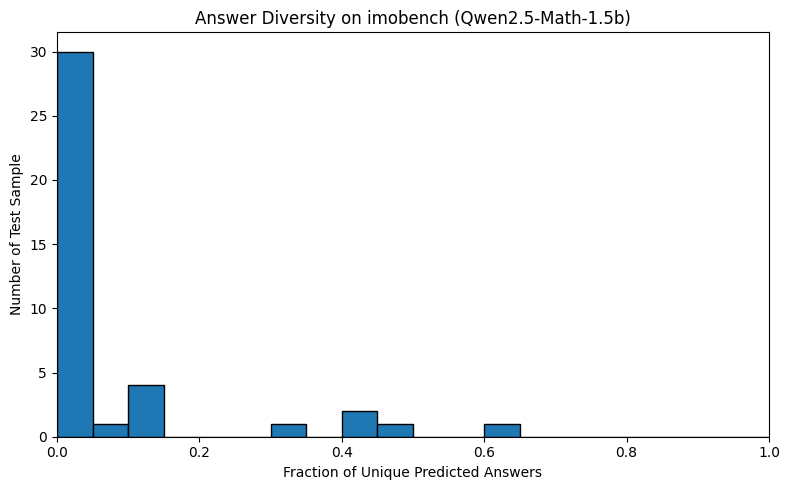

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(
    pred_answers[pred_answers['prefix'] == "To" ]['fraction_correct_pred'],
    bins=20,
    edgecolor='black',
    range=(0, 1)
)

# plt.hist(
#     pred_answers[pred_answers['prefix'] == "Given" ]['fraction_correct_pred'],
#     bins=20,
#     edgecolor='black',
#     range=(0, 1)
# )

# plt.hist(
#     pred_answers[pred_answers['prefix'] == "Let" ]['fraction_correct_pred'],
#     bins=20,
#     edgecolor='black',
#     range=(0, 1)
# )


plt.xlim(0, 1)
plt.xlabel('Fraction of Unique Predicted Answers')
plt.ylabel('Number of Test Sample')
plt.title(f'Answer Diversity on {args.dataset_name} (Qwen2.5-Math-1.5b)')
plt.tight_layout()
plt.show()

In [10]:
# from wordcloud import WordCloud
# from collections import Counter

In [11]:
# first_tokens = generation_df[(generation_df.question_id == 21) & generation_df.is_correct].response.apply(lambda x: tokenizer.tokenize(x.split()[0])[0])
# first_tokens = generation_df[generation_df.is_correct].response.apply(lambda x: tokenizer.tokenize(x[:100])[0] if len(x) > 0 else "N/a")
first_tokens = generation_df.response.apply(lambda x: tokenizer.tokenize(x[:30])[0].replace("$", "\$") if len(x) > 0 else "N/a")

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_2400639/1207164346.py:3: SyntaxWarning: invalid escape sequence '\$'
  first_tokens = generation_df.response.apply(lambda x: tokenizer.tokenize(x[:30])[0].replace("$", "\$") if len(x) > 0 else "N/a")


In [12]:
first_token_frequencies = Counter(first_tokens.values)
# wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, colormap="viridis").generate_from_frequencies(first_token_frequencies)
# # 4. Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off") # Remove axes for a cleaner look
# plt.title("First Tokens")
# plt.show()

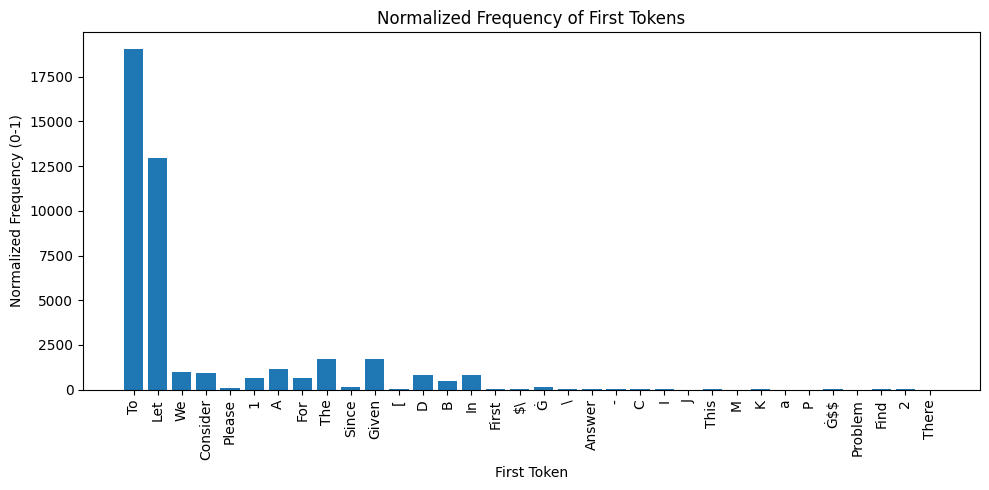

In [13]:
plt.figure(figsize=(10, 5))
# Normalize frequencies to 0-1
vals = np.array(list(first_token_frequencies.values()))
normalized_vals = vals 
plt.bar(first_token_frequencies.keys(), normalized_vals)
plt.xticks(rotation=90)
plt.xlabel('First Token')
plt.ylabel('Normalized Frequency (0-1)')
plt.title('Normalized Frequency of First Tokens')
# plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [14]:
import torch
import random
from notebooks.notebook_utils import load_deberta_tokenizer_and_model
from collections import defaultdict
from tqdm import tqdm

In [15]:
@torch.inference_mode()
def classifier_score(prompt: str, s1: str, s2: str, model: str, max_length=128):
    if model == 'deberta':
        tokenizer, model = load_deberta_tokenizer_and_model()
    else:
        raise ValueError("Unsupported model type. Use 'deberta'.")
    
    input_ids = [tokenizer.cls_token_id]
    for s in [s1, s2]:
        input_ids.extend(
            tokenizer.encode(
                s,
                truncation=True,
                max_length=max_length,
                add_special_tokens=False,
            )
        )
        input_ids.append(tokenizer.sep_token_id)
        prompt_len = input_ids.index(tokenizer.sep_token_id) + 1
    token_type_ids = [0] * prompt_len + [1] * (len(input_ids) - prompt_len)

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    iids = torch.tensor(input_ids, device=DEVICE, dtype=torch.int64)
    tids = torch.tensor(token_type_ids, device=DEVICE, dtype=torch.int64)

    outputs = model(input_ids=iids.unsqueeze(0), token_type_ids=tids.unsqueeze(0))
    score = outputs["logits"].softmax(-1)[0, 1]
    return score.cpu().item()

In [16]:
grouped_df = generation_df[generation_df['is_valid']].groupby(['question_id', 'prompt_id', 'prefix', 'gt_answer'])
grouped_response_df = grouped_df.response.apply(list).rename("responses")

In [33]:
print(grouped_response_df.iloc[12][5])

 1. We need to find all positive integers \( N \) such that the sum of the quotients \(\frac{ab}{N+1}\) for each pair \((a, b)\) where \(1 \le a, b \le N\) is equal to \(\frac{N^3 - N^2 + 2}{4}\).

2. First, let's calculate the sum of the quotients \(\frac{ab}{N+1}\) for all pairs \((a, b)\) where \(1 \le a, b \le N\). The sum of all such quotients can be expressed as:
   \[
   \sum_{a=1}^N \sum_{b=1}^N \frac{ab}{N+1} = \frac{1}{N+1} \sum_{a=1}^N \sum_{b=1}^N ab.
   \]

3. The double sum \(\sum_{a=1}^N \sum_{b=1}^N ab\) can be simplified as:
   \[
   \sum_{a=1}^N \sum_{b=1}^N ab = \left( \sum_{a=1}^N a \right) \left( \sum_{b=1}^N b \right) = \left( \frac{N(N+1)}{2} \right) \left( \frac{N(N+1)}{2} \right) = \left( \frac{N(N+1)}{2} \right)^2.
   \]

4. Therefore, the sum of the quotients is:
   \[
   \frac{1}{N+1} \left( \frac{N(N+1)}{2} \right)^2 = \frac{1}{N+1} \cdot \frac{N^2 (N+1)^2}{4} = \frac{N^2 (N+1)}{4}.
   \]

5. We need this sum to be equal to \(\frac{N^3 - N^2 + 2}{4}\). So, 

In [18]:
prefixes = generation_df.prefix.unique().tolist()
prefix_responses = {}
question_id = "imo-bench-algebra-001"
for prefix in prefixes:
    try:
        prefix_responses[prefix] = grouped_response_df[(question_id, question_id, prefix)].values[0]
    except KeyError:
        pass
prefixes = list(prefix_responses.keys())
prefixes = sorted(prefixes, key=lambda x: len(prefix_responses[x]), reverse=True)
# prefixes = random.sample(prefixes, 4)

# prefixes = ['To'] + prefixes[1:10]
print(prefixes)

['To', 'For', 'Let', '1', 'We', 'The', 'Given', 'Ġ', '-', 'Please', 'First', 'Consider', 'In']


In [ ]:
# print(prefix_responses['Solution'][20])

KeyError: 'Solution'

In [21]:
intra_group_sim = defaultdict(list)

for prefix in prefixes:
    responses = prefix_responses[prefix]
    indices = list(range(len(responses)))
    for i in tqdm(range(100)):
        s1, s2 = random.sample(indices, 2)
        intra_group_sim[prefix].append(classifier_score(None, responses[s1], responses[s2], "deberta"))

  0%|          | 0/100 [00:00<?, ?it/s]/scratch1/hnn5071/workspace/rm-limeval/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Dis

ValueError: Sample larger than population or is negative

In [22]:
# Show a quick summary (mean similarity for each prefix pair)
for prefix in intra_group_sim:
    print(f"{prefix} mean inter-group similarity: {np.mean(intra_group_sim[prefix]):.3f}")

To mean inter-group similarity: 0.788
For mean inter-group similarity: 0.388
Let mean inter-group similarity: 0.158
1 mean inter-group similarity: 0.213
We mean inter-group similarity: 0.360
The mean inter-group similarity: 0.168
Given mean inter-group similarity: 0.078
Ġ mean inter-group similarity: 0.223
- mean inter-group similarity: 0.250
Please mean inter-group similarity: 0.173
First mean inter-group similarity: 0.363
Consider mean inter-group similarity: 0.085


In [22]:
# Compute inter-group similarity between prefixes
from itertools import combinations

inter_group_sim = {}

# Get all pairs of prefixes
prefix_pairs = list(combinations(prefixes, 2))

for prefix1, prefix2 in prefix_pairs:
    responses1 = prefix_responses[prefix1]
    responses2 = prefix_responses[prefix2]
    indices1 = list(range(len(responses1)))
    indices2 = list(range(len(responses2)))
    sims = []
    for i in tqdm(range(100)):
        s1 = random.choice(indices1)
        s2 = random.choice(indices2)
        sim = classifier_score(None, responses1[s1], responses2[s2], "deberta")
        sims.append(sim)
    inter_group_sim[(prefix1, prefix2)] = sims


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


In [23]:
# Show a quick summary (mean similarity for each prefix pair)
for pair in inter_group_sim:
    print(f"{pair} mean inter-group similarity: {np.mean(inter_group_sim[pair]):.3f}")

('To', '.Ċ') mean inter-group similarity: 0.902
('To', 'ĠTo') mean inter-group similarity: 0.898
('To', ':ĊĊ') mean inter-group similarity: 0.904
('To', 'l') mean inter-group similarity: 0.895
('To', 'We') mean inter-group similarity: 0.569
('To', '.') mean inter-group similarity: 0.902
('To', '\\') mean inter-group similarity: 0.893
('To', 'Let') mean inter-group similarity: 0.858
('To', 'The') mean inter-group similarity: 0.767
('To', 'Ġto') mean inter-group similarity: 0.872
('To', 's') mean inter-group similarity: 0.896
('To', '```') mean inter-group similarity: 0.151
('To', 't') mean inter-group similarity: 0.897
('To', '4') mean inter-group similarity: 0.901
('To', '##') mean inter-group similarity: 0.898
('To', 'For') mean inter-group similarity: 0.608
('To', 'e') mean inter-group similarity: 0.896
('To', 'le') mean inter-group similarity: 0.898
('To', ',') mean inter-group similarity: 0.900
('To', ':Ċ') mean inter-group similarity: 0.904
('To', '-') mean inter-group similarity:

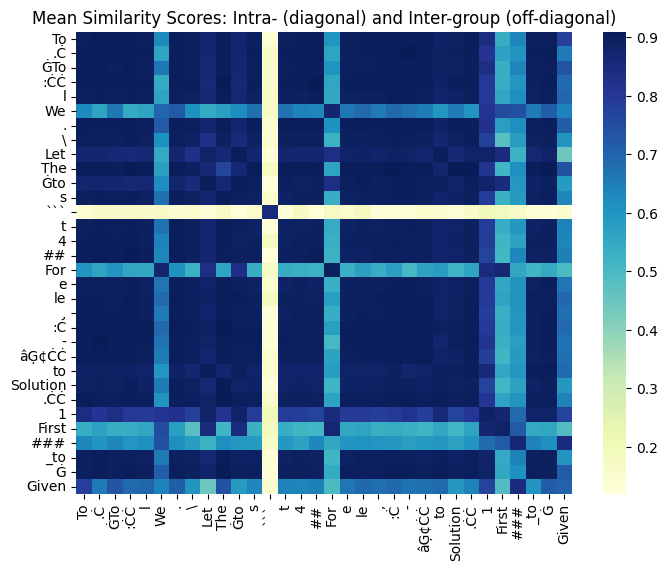

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare all prefixes and pairs
# prefixes = ["Given", "To", "We", "Let"]

# Initialize correlation matrix (prefix x prefix)
corr_matrix = pd.DataFrame(index=prefixes, columns=prefixes, dtype=float)

# Fill diagonal with intra-group similarity means
for prefix in prefixes:
    corr_matrix.loc[prefix, prefix] = np.median(intra_group_sim[prefix])

# Fill off-diagonal with inter-group similarity means
for p1 in prefixes:
    for p2 in prefixes:
        if p1 != p2:
            # inter_group_sim uses tuple with p1, p2 in sorted order
            pair = (p1, p2) if (p1, p2) in inter_group_sim else (p2, p1)
            if pair in inter_group_sim:
                corr_matrix.loc[p1, p2] = np.median(inter_group_sim[pair])
            else:
                # fallback (should not happen)
                corr_matrix.loc[p1, p2] = np.nan

# Plot correlation table as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.astype(float), annot=False, fmt=".3f", cmap="YlGnBu")
plt.title("Mean Similarity Scores: Intra- (diagonal) and Inter-group (off-diagonal)")
plt.show()
